In [1]:
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchmetrics import Dice

from progressBar import printProgressBar

import medicalDataLoader
import argparse
from utils import *
from losses import *
from UNet_Base import *
import random
import torch
import pdb
import cv2

import matplotlib.pyplot as plt

from UNet_Attention import *

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def runTraining():
    ## DEFINE HYPERPARAMETERS (batch_size > 1)
    batch_size = 8
    batch_size_val = 8
    lr = 0.001     # Learning Rate
    weight_decay = 1e-5
    epoch = 200 # Number of epochs

    root_dir = './Data/'

    ## DEFINE THE TRANSFORMATIONS TO DO AND THE VARIABLES FOR TRAINING AND VALIDATION

    transform = transforms.Compose([
    transforms.ToTensor()
    ])

    mask_transform = transforms.Compose([
    transforms.ToTensor()
    ])

    train_set_full = medicalDataLoader.MedicalImageDataset('train',
                                                    root_dir,
                                                    transform=transform,
                                                    mask_transform=mask_transform,
                                                    augment=False,
                                                    equalize=False)
    
    unlabeled_set = medicalDataLoader.MedicalImageDataset('unlabeled',
                                                          root_dir,
                                                          transform=transform,
                                                          mask_transform=mask_transform,
                                                          equalize=None)
    
    train_set = torch.utils.data.ConcatDataset([train_set_full, unlabeled_set])

    train_loader = DataLoader(train_set,
                            batch_size=batch_size,
                            worker_init_fn=np.random.seed(0),
                            num_workers=0,
                            shuffle=True)


    val_set = medicalDataLoader.MedicalImageDataset('val',
                                                root_dir,
                                                transform=transform,
                                                mask_transform=mask_transform,
                                                equalize=False)

    val_loader = DataLoader(val_set,
                        batch_size=batch_size_val,
                        worker_init_fn=np.random.seed(0),
                        num_workers=0,
                        shuffle=False)


    ## INITIALIZE YOUR MODEL
    num_classes = 4 # NUMBER OF CLASSES

    print("~~~~~~~~~~~ Creating the UNet model ~~~~~~~~~~")
    modelName = 'Att_UNet_Model'
    print(" Model Name: {}".format(modelName))

    ## CREATION OF YOUR MODEL
    # net = UNet(num_classes)
    net = AttU_Net(num_classes)

    print("Total params: {0:,}".format(sum(p.numel() for p in net.parameters() if p.requires_grad)))

    # DEFINE YOUR OUTPUT COMPONENTS (e.g., SOFTMAX, LOSS FUNCTION, ETC)
    softMax = torch.nn.Softmax(dim=1)
    CE_loss = torch.nn.CrossEntropyLoss()
    dice_loss = DiceLoss(num_classes)
    ## PUT EVERYTHING IN GPU RESOURCES    
    if torch.cuda.is_available():
        net.cuda()
        softMax.cuda()
        CE_loss.cuda()
        dice_loss.cuda()

    ## DEFINE YOUR OPTIMIZER
    optimizer = torch.optim.Adam(params=net.parameters(),lr=lr,weight_decay=weight_decay)


    ### To save statistics ####
    lossTotalTraining = []
    lossTotalValidation = []
    Best_loss_val = 1000
    BestEpoch = 0

    directory = 'Results/Statistics/' + modelName

    print("~~~~~~~~~~~ Starting the training ~~~~~~~~~~")
    if os.path.exists(directory)==False:
        os.makedirs(directory)

    ## START THE TRAINING

    ## FOR EACH EPOCH
    for i in range(epoch):
        net.train()
        lossEpoch = []
        vlossEpoch = []
        DSCEpoch = []
        vDSCEpoch = []
        DSCEpoch_w = []
        num_batches = len(train_loader)
        v_num_batches = len(val_loader)
        ########## Training ##########
        net.train(True)
        ## FOR EACH BATCH
        for j, data in enumerate(train_loader):
            ### Set to zero all the gradients
            net.zero_grad()
            optimizer.zero_grad()

            ## GET IMAGES, LABELS and IMG NAMES
            images, labels, img_names = data

            ### From numpy to torch variables
            labels = to_var(labels)
            images = to_var(images)

            ################### Train ###################
            #-- The CNN makes its predictions (forward pass)
            net_predictions = net.forward(images)

            #-- Compute the losses --#
            # THIS FUNCTION IS TO CONVERT LABELS TO A FORMAT TO BE USED IN THIS CODE
            segmentation_classes = getTargetSegmentation(labels)
            # COMPUTE THE LOSS
            CE_loss_value = CE_loss(softMax(net_predictions),segmentation_classes)
            dice_loss_value = dice_loss(softMax(net_predictions),segmentation_classes.unsqueeze(1))
            lossTotal = 0.5*(CE_loss_value + dice_loss_value)

            # DO THE STEPS FOR BACKPROP (two things to be done in pytorch)
            lossTotal.backward()
            optimizer.step()
            # THIS IS JUST TO VISUALIZE THE TRAINING 
            lossEpoch.append(CE_loss_value.cpu().data.numpy())
            DSCEpoch.append(dice_loss_value.cpu().data.numpy())
            print
            printProgressBar(j + 1, num_batches,
                                prefix="[Training] Epoch: {} ".format(i),
                                length=15,
                                suffix=" CE_Loss: {:.4f}, dice_loss:  {:.4f}".format(CE_loss_value,dice_loss_value))

        lossEpoch = np.asarray(lossEpoch)
        lossEpoch = lossEpoch.mean()
        DSCEpoch = np.asarray(DSCEpoch)
        DSCEpoch = DSCEpoch.mean()
        lossTotalTraining.append(lossEpoch+DSCEpoch)
        printProgressBar(num_batches, num_batches,
                                done="[Training] Epoch: {}, LossG: {:.4f}".format(i,lossEpoch+DSCEpoch))
        
        ######### Validation ############
        net.train(False)
        for j, vdata in enumerate(val_loader):
            vimages, vlabels, vimg_names = vdata
            vlabels = to_var(vlabels)
            vimages = to_var(vimages)
            voutputs = net(vimages)
            vsegmentation_classes = getTargetSegmentation(vlabels)
            vloss = CE_loss(softMax(voutputs), vsegmentation_classes)
            vdice = dice_loss(softMax(voutputs), vsegmentation_classes.unsqueeze(1))
            vlossTotal = 0.5*(vloss + vdice)
            vlossEpoch.append(vloss.cpu().data.numpy())
            vDSCEpoch.append(vdice.cpu().data.numpy())
            printProgressBar(j + 1, num_batches,
                                prefix="[Validation] Epoch: {} ".format(i),
                                length=15,
                                suffix=" CE_val_Loss: {:.4f}, dice_val_loss: {:.4f}".format(vloss,vdice))
            
        vlossEpoch = np.asarray(vlossEpoch)
        vlossEpoch = vlossEpoch.mean()
        vDSCEpoch = np.asarray(vDSCEpoch)
        vDSCEpoch = vDSCEpoch.mean()
        lossTotalValidation.append(vlossEpoch+vDSCEpoch)
        printProgressBar(v_num_batches, v_num_batches,
                                done="[Validation] Epoch: {}, val_LossG: {:.4f}".format(i,vlossEpoch+vDSCEpoch))



        ## THIS IS HOW YOU WILL SAVE THE TRAINED MODELS AFTER EACH EPOCH. 
        ## WARNING!!!!! YOU DON'T WANT TO SAVE IT AT EACH EPOCH, BUT ONLY WHEN THE MODEL WORKS BEST ON THE VALIDATION SET!!
        if not os.path.exists('./models/' + modelName):
            os.makedirs('./models/' + modelName)
        if  vlossEpoch < Best_loss_val:
            Best_loss_val = vlossEpoch
            BestEpoch = i 
            torch.save(net.state_dict(), './models/' + modelName + '/'  + str(BestEpoch)+'_Epoch')
            
        np.save(os.path.join(directory, 'TrainLosses.npy'), lossTotalTraining)
        np.save(os.path.join(directory, 'ValLosses.npy'), lossTotalValidation)

runTraining()


In [ ]:
def runTrainingTversky():
    ## DEFINE HYPERPARAMETERS (batch_size > 1)
    batch_size = 8
    batch_size_val = 8
    lr = 0.0001     # Learning Rate
    weight_decay = 1e-5
    alpha = 0.3 # 0.5 0.3 0.8
    beta = 0.8 # 0.5 0.8 0.3
    epoch = 200 # Number of epochs

    root_dir = './Data/'

    ## DEFINE THE TRANSFORMATIONS TO DO AND THE VARIABLES FOR TRAINING AND VALIDATION

    transform = transforms.Compose([
    transforms.ToTensor()
    ])

    mask_transform = transforms.Compose([
    transforms.ToTensor()
    ])

    train_set_full = medicalDataLoader.MedicalImageDataset('train',
                                                    root_dir,
                                                    transform=transform,
                                                    mask_transform=mask_transform,
                                                    augment=False,
                                                    equalize=False)

    train_loader_full = DataLoader(train_set_full,
                            batch_size=batch_size,
                            worker_init_fn=np.random.seed(0),
                            num_workers=0,
                            shuffle=True)


    val_set = medicalDataLoader.MedicalImageDataset('val',
                                                root_dir,
                                                transform=transform,
                                                mask_transform=mask_transform,
                                                equalize=False)

    val_loader = DataLoader(val_set,
                        batch_size=batch_size_val,
                        worker_init_fn=np.random.seed(0),
                        num_workers=0,
                        shuffle=False)


    ## INITIALIZE YOUR MODEL
    num_classes = 4 # NUMBER OF CLASSES

    print("~~~~~~~~~~~ Creating the UNet model ~~~~~~~~~~")
    modelName = f'Tversky_Model_{alpha}_{beta}_att'
    print(" Model Name: {}".format(modelName))

    ## CREATION OF YOUR MODEL
    # net = UNet(num_classes)
    net = AttU_Net(num_classes)


    print("Total params: {0:,}".format(sum(p.numel() for p in net.parameters() if p.requires_grad)))

    # DEFINE YOUR OUTPUT COMPONENTS (e.g., SOFTMAX, LOSS FUNCTION, ETC)
    softMax = torch.nn.Softmax(dim=1)
    tversky = TverskyLoss(alpha=alpha,beta=beta,n_classes=num_classes)
    ## PUT EVERYTHING IN GPU RESOURCES    
    if torch.cuda.is_available():
        net.cuda()
        softMax.cuda()
        tversky.cuda()


    ## DEFINE YOUR OPTIMIZER
    optimizer = torch.optim.Adam(params=net.parameters(),lr=lr,weight_decay=weight_decay)


    ### To save statistics ####
    lossTotalTraining = []
    lossTotalValidation = []
    Best_loss_val = 1000
    BestEpoch = 0

    directory = 'Results/Statistics/' + modelName

    print("~~~~~~~~~~~ Starting the training ~~~~~~~~~~")
    if os.path.exists(directory)==False:
        os.makedirs(directory)

    ## START THE TRAINING

    ## FOR EACH EPOCH
    for i in range(epoch):
        net.train()
        lossEpoch = []
        vlossEpoch = []
        num_batches = len(train_loader_full)
        v_num_batches = len(val_loader)
        ########## Training ##########
        net.train(True)
        ## FOR EACH BATCH
        for j, data in enumerate(train_loader_full):
            ### Set to zero all the gradients
            net.zero_grad()
            optimizer.zero_grad()

            ## GET IMAGES, LABELS and IMG NAMES
            images, labels, img_names = data

            ### From numpy to torch variables
            labels = to_var(labels)
            images = to_var(images)

            ################### Train ###################
            #-- The CNN makes its predictions (forward pass)
            net_predictions = net.forward(images)

            #-- Compute the losses --#
            # THIS FUNCTION IS TO CONVERT LABELS TO A FORMAT TO BE USED IN THIS CODE
            segmentation_classes = getTargetSegmentation(labels)
            # COMPUTE THE LOSS
            tversky_loss_value = tversky(softMax(net_predictions),segmentation_classes)
            lossTotal = tversky_loss_value

            # DO THE STEPS FOR BACKPROP (two things to be done in pytorch)
            lossTotal.backward()
            optimizer.step()
            # THIS IS JUST TO VISUALIZE THE TRAINING 
            lossEpoch.append(tversky_loss_value.cpu().data.numpy())
            print
            printProgressBar(j + 1, num_batches,
                                prefix="[Training] Epoch: {} ".format(i),
                                length=15,
                                suffix=" Tversky_Loss: {:.4f}".format(tversky_loss_value))

        lossEpoch = np.asarray(lossEpoch)
        lossEpoch = lossEpoch.mean()
        lossTotalTraining.append(lossEpoch)
        printProgressBar(num_batches, num_batches,
                                done="[Training] Epoch: {}, LossG: {:.4f}".format(i,lossEpoch))
        
        ######### Validation ############
        net.train(False)
        for j, vdata in enumerate(val_loader):
            vimages, vlabels, vimg_names = vdata
            vlabels = to_var(vlabels)
            vimages = to_var(vimages)
            voutputs = net(vimages)
            vsegmentation_classes = getTargetSegmentation(vlabels)
            vloss = tversky(softMax(voutputs), vsegmentation_classes)
            vlossTotal = vloss
            vlossEpoch.append(vloss.cpu().data.numpy())
            printProgressBar(j + 1, num_batches,
                                prefix="[Validation] Epoch: {} ".format(i),
                                length=15,
                                suffix=" Tversky_val_Loss: {:.4f}".format(vloss))
            
        vlossEpoch = np.asarray(vlossEpoch)
        vlossEpoch = vlossEpoch.mean()

        lossTotalValidation.append(vlossEpoch)
        printProgressBar(v_num_batches, v_num_batches,
                                done="[Validation] Epoch: {}, val_LossG: {:.4f}".format(i,vlossEpoch))



        ## THIS IS HOW YOU WILL SAVE THE TRAINED MODELS AFTER EACH EPOCH. 
        ## WARNING!!!!! YOU DON'T WANT TO SAVE IT AT EACH EPOCH, BUT ONLY WHEN THE MODEL WORKS BEST ON THE VALIDATION SET!!
        if not os.path.exists('./models/' + modelName):
            os.makedirs('./models/' + modelName)
        if  vlossEpoch < Best_loss_val:
            Best_loss_val = vlossEpoch
            BestEpoch = i 
            torch.save(net.state_dict(), './models/' + modelName + '/'  + str(BestEpoch)+'_Epoch')
            
        np.save(os.path.join(directory, 'TrainLosses.npy'), lossTotalTraining)
        np.save(os.path.join(directory, 'ValLosses.npy'), lossTotalValidation)

runTrainingTversky()

In [ ]:
def runTrainingFocalTversky():
    ## DEFINE HYPERPARAMETERS (batch_size > 1)
    batch_size = 32
    batch_size_val = 16
    lr = 0.001     # Learning Rate
    weight_decay = 1e-5
    alpha = 0.3 # 0.5 0.3 0.8
    beta = 0.8 # 0.5 0.8 0.3
    gamma = 0.5
    epoch = 200 # Number of epochs

    root_dir = './Data/'

    ## DEFINE THE TRANSFORMATIONS TO DO AND THE VARIABLES FOR TRAINING AND VALIDATION

    transform = transforms.Compose([
    transforms.ToTensor()
    ])

    mask_transform = transforms.Compose([
    transforms.ToTensor()
    ])

    train_set_full = medicalDataLoader.MedicalImageDataset('train',
                                                    root_dir,
                                                    transform=transform,
                                                    mask_transform=mask_transform,
                                                    augment=False,
                                                    equalize=False)

    train_loader_full = DataLoader(train_set_full,
                            batch_size=batch_size,
                            worker_init_fn=np.random.seed(0),
                            num_workers=0,
                            shuffle=True)


    val_set = medicalDataLoader.MedicalImageDataset('val',
                                                root_dir,
                                                transform=transform,
                                                mask_transform=mask_transform,
                                                equalize=False)

    val_loader = DataLoader(val_set,
                        batch_size=batch_size_val,
                        worker_init_fn=np.random.seed(0),
                        num_workers=0,
                        shuffle=False)


    ## INITIALIZE YOUR MODEL
    num_classes = 4 # NUMBER OF CLASSES

    print("~~~~~~~~~~~ Creating the UNet model ~~~~~~~~~~")
    modelName = f'Tversky_Model_{alpha}_{beta}_focal'
    print(" Model Name: {}".format(modelName))

    ## CREATION OF YOUR MODEL
    net = UNet(num_classes)
    print("Total params: {0:,}".format(sum(p.numel() for p in net.parameters() if p.requires_grad)))

    # DEFINE YOUR OUTPUT COMPONENTS (e.g., SOFTMAX, LOSS FUNCTION, ETC)
    softMax = torch.nn.Softmax(dim=1)
    tversky = FocalTverskyLoss(alpha=alpha,beta=beta,gamma=gamma,n_classes=num_classes)
    ## PUT EVERYTHING IN GPU RESOURCES    
    if torch.cuda.is_available():
        net.cuda()
        softMax.cuda()
        tversky.cuda()


    ## DEFINE YOUR OPTIMIZER
    optimizer = torch.optim.Adam(params=net.parameters(),lr=lr,weight_decay=weight_decay)


    ### To save statistics ####
    lossTotalTraining = []
    lossTotalValidation = []
    Best_loss_val = 1000
    BestEpoch = 0

    directory = 'Results/Statistics/' + modelName

    print("~~~~~~~~~~~ Starting the training ~~~~~~~~~~")
    if os.path.exists(directory)==False:
        os.makedirs(directory)

    ## START THE TRAINING

    ## FOR EACH EPOCH
    for i in range(epoch):
        net.train()
        lossEpoch = []
        vlossEpoch = []
        num_batches = len(train_loader_full)
        v_num_batches = len(val_loader)
        ########## Training ##########
        net.train(True)
        ## FOR EACH BATCH
        for j, data in enumerate(train_loader_full):
            ### Set to zero all the gradients
            net.zero_grad()
            optimizer.zero_grad()

            ## GET IMAGES, LABELS and IMG NAMES
            images, labels, img_names = data

            ### From numpy to torch variables
            labels = to_var(labels)
            images = to_var(images)

            ################### Train ###################
            #-- The CNN makes its predictions (forward pass)
            net_predictions = net.forward(images)

            #-- Compute the losses --#
            # THIS FUNCTION IS TO CONVERT LABELS TO A FORMAT TO BE USED IN THIS CODE
            segmentation_classes = getTargetSegmentation(labels)
            # COMPUTE THE LOSS
            tversky_loss_value = tversky(softMax(net_predictions),segmentation_classes)
            lossTotal = tversky_loss_value

            # DO THE STEPS FOR BACKPROP (two things to be done in pytorch)
            lossTotal.backward()
            optimizer.step()
            # THIS IS JUST TO VISUALIZE THE TRAINING 
            lossEpoch.append(tversky_loss_value.cpu().data.numpy())
            print
            printProgressBar(j + 1, num_batches,
                                prefix="[Training] Epoch: {} ".format(i),
                                length=15,
                                suffix=" Tversky_Loss: {:.4f}".format(tversky_loss_value))

        lossEpoch = np.asarray(lossEpoch)
        lossEpoch = lossEpoch.mean()
        lossTotalTraining.append(lossEpoch)
        printProgressBar(num_batches, num_batches,
                                done="[Training] Epoch: {}, LossG: {:.4f}".format(i,lossEpoch))
        
        ######### Validation ############
        net.train(False)
        for j, vdata in enumerate(val_loader):
            vimages, vlabels, vimg_names = vdata
            vlabels = to_var(vlabels)
            vimages = to_var(vimages)
            voutputs = net(vimages)
            vsegmentation_classes = getTargetSegmentation(vlabels)
            vloss = tversky(softMax(voutputs), vsegmentation_classes)
            vlossTotal = vloss
            vlossEpoch.append(vloss.cpu().data.numpy())
            printProgressBar(j + 1, num_batches,
                                prefix="[Validation] Epoch: {} ".format(i),
                                length=15,
                                suffix=" Tversky_val_Loss: {:.4f}".format(vloss))
            
        vlossEpoch = np.asarray(vlossEpoch)
        vlossEpoch = vlossEpoch.mean()

        lossTotalValidation.append(vlossEpoch)
        printProgressBar(v_num_batches, v_num_batches,
                                done="[Validation] Epoch: {}, val_LossG: {:.4f}".format(i,vlossEpoch))



        ## THIS IS HOW YOU WILL SAVE THE TRAINED MODELS AFTER EACH EPOCH. 
        ## WARNING!!!!! YOU DON'T WANT TO SAVE IT AT EACH EPOCH, BUT ONLY WHEN THE MODEL WORKS BEST ON THE VALIDATION SET!!
        if not os.path.exists('./models/' + modelName):
            os.makedirs('./models/' + modelName)
        if  vlossEpoch < Best_loss_val:
            Best_loss_val = vlossEpoch
            BestEpoch = i 
            torch.save(net.state_dict(), './models/' + modelName + '/'  + str(BestEpoch)+'_Epoch')
            
        np.save(os.path.join(directory, 'TrainLosses.npy'), lossTotalTraining)
        np.save(os.path.join(directory, 'ValLosses.npy'), lossTotalValidation)

runTrainingFocalTversky()

In [ ]:
# net = UNet(num_classes=4) # base unet
net = AttU_Net(num_classes=4) # attention unet

net.load_state_dict(torch.load(r'models\Tversky_Model_0.3_0.8_att\198_Epoch'))
net.eval()

In [46]:
transform = transforms.Compose([
    transforms.ToTensor()
    ])
test_image = cv2.imread(r"Data/val/Img/patient012_01_10.png",0)
test_image = transform(test_image).float()
test_image = test_image.unsqueeze(0)
test_image_label = cv2.imread(r"Data/val/GT/patient012_01_10.png",0)
test_image_label = transform(test_image_label).float()

In [47]:
softMax = torch.nn.Softmax(dim=1)
with torch.no_grad():
    preds = softMax(net.forward(test_image))

color_map = {0:0,1:1/3,2:2/3,3:1}
preds = predToSegmentation(preds)
seg = torch.zeros((256,256))
for i in range(len(preds[0])):
    for x in range(256):
        for y in range(256):
            if preds[0][i][x][y] == 1:
                seg[x][y] = color_map[i]

Text(0.5, 1.0, 'prediction mask')

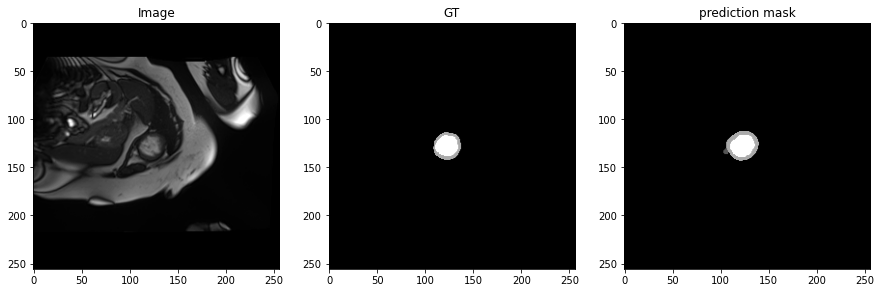

In [48]:
fig,axs = plt.subplots(nrows=1,ncols=3,figsize=(15,15))
axs[0].imshow(test_image.squeeze(0)[0],cmap='gray')
axs[0].set_title('Image')
axs[1].imshow(test_image_label[0],cmap='gray')
axs[1].set_title('GT')
axs[2].imshow(seg,cmap='gray')
axs[2].set_title('prediction mask')

In [50]:
HD = computeHD(preds[0][1:],test_image_label[0])
HD

12.410307119696

In [49]:
DSC = computeDSC(preds[0][1:],test_image_label[0])
DSC

0.4073139091124703

In [ ]:
train_loss = np.load(r'Results\Statistics\Tversky_Model_0.3_0.8_att\TrainLosses.npy')
val_loss = np.load(r'Results\Statistics\Tversky_Model_0.3_0.8_att\ValLosses.npy')
plt.plot(train_loss,label='train loss')
plt.plot(val_loss,label='val loss')
plt.legend()

In [ ]:
print(min(train_loss))
print(min(val_loss))